In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as sc 
import numpy as np
import cvxpy as cvx
import pickle
import matplotlib.dates as mdates

import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import covariance_functions.general_functions as gf
import covariance_functions.em_functions as em
import covariance_functions.ewma_functions as ewma
import covariance_functions.regularization_functions as reg
import covariance_functions.backtest_functions as bt

importlib.reload(gf)
importlib.reload(em)
importlib.reload(ewma)
importlib.reload(reg)
importlib.reload(bt)

from covariance_functions.em_functions import *
from covariance_functions.ewma_functions import *
from covariance_functions.ewma_functions import _ewma_cov
from covariance_functions.ewma_functions import iterated_ewma
from covariance_functions.general_functions import *
from covariance_functions.regularization_functions import *
from covariance_functions.backtest_functions import *

import warnings
warnings.filterwarnings("ignore")

import start
import end


# Import Data and Data Pre-Processing

In [4]:
# Import returns for the 238-asset universe
returns = pd.read_csv('data/returns_large_universe.csv')
returns = returns.set_index('date')
returns = returns.rename_axis('Date', axis='index')
returns.index = pd.to_datetime(returns.index, format='%Y-%m-%d')

In [5]:
vix = pd.read_csv('data/vix.csv')
vix['Date'] = pd.to_datetime(vix['Date'])
vix = vix.set_index('Date')

In [6]:
mapping_data = pd.read_csv('data/permno_to_ticker_mapping.csv')
mapping_df = pd.DataFrame(mapping_data)
returns.columns = returns.columns.astype(str)
permno_to_ticker = dict(zip(mapping_df['PERMNO'].astype(str), mapping_df['tic']))
returns.rename(columns=permno_to_ticker, inplace=True)

In [7]:
returns
csv_file_path = 'data/returns_data.csv'
returns.to_csv(csv_file_path)
csv_file_path

'data/returns_data.csv'

In [8]:
returns

,MSFT,GE,CSCO,WMT,INTC,XOM,IBM,C,ORCL,T,...,FE,AB,HBAN,HSY,HES,CINF,ECL,SKM,ZION,NUE
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.001606,-0.030695,0.008751,-0.032550,0.056948,-0.029480,0.071842,-0.050505,0.054099,-0.032051,...,-0.027548,-0.006263,-0.060209,-0.022398,-0.039648,-0.021042,-0.036741,0.009772,-0.062302,-0.009122
2000-01-04,-0.033780,-0.038750,-0.056102,-0.039252,-0.046695,-0.017586,-0.030811,-0.042553,-0.088360,-0.062252,...,0.000000,-0.004202,-0.030641,-0.037736,-0.019495,-0.001024,-0.026534,-0.103226,-0.048423,-0.010357
2000-01-05,0.010544,-0.005202,-0.003064,-0.019455,0.008289,0.054516,0.035137,0.003704,-0.052815,0.015537,...,0.036827,0.004219,-0.025862,0.004202,-0.008187,0.010246,0.039182,-0.028777,-0.001183,0.027907
2000-01-06,-0.033498,0.015577,-0.016595,0.010913,-0.058296,0.049383,-0.008621,0.065191,-0.058824,-0.021001,...,0.002732,0.016807,0.035398,0.026499,0.021226,0.006085,0.044262,-0.007407,0.014218,0.009050
2000-01-07,0.013068,0.038721,0.058750,0.075564,0.041270,-0.000735,-0.013043,-0.002309,0.076823,0.008571,...,0.005450,0.033058,0.008547,0.002717,0.042725,0.020161,0.000000,0.123134,0.002336,0.003363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.002267,0.000245,0.003381,0.002021,0.004621,0.026445,0.005466,0.006138,0.004473,0.002189,...,0.014493,-0.015795,0.010065,0.004044,0.047154,0.006843,0.010416,0.010531,0.003521,-0.006062
2022-12-27,-0.007414,0.012838,0.001053,0.000278,-0.005749,0.013894,0.005436,0.002937,0.001608,0.008192,...,0.006190,-0.005544,-0.000712,-0.000636,0.012211,-0.000191,0.006296,0.011843,0.008050,0.003380
2022-12-28,-0.010255,-0.010502,-0.009678,-0.017523,-0.015420,-0.016426,-0.016852,0.005181,-0.008027,-0.013001,...,-0.004496,-0.027876,-0.004274,-0.012133,-0.033261,-0.016565,-0.011344,-0.015918,-0.017813,-0.017211


In [8]:
vix.head()

,vix
Date,
2000-01-03,24.21
2000-01-03,24.21
2000-01-04,27.01
2000-01-04,27.01
2000-01-05,26.41


# Constructing CM-IEWMA

In [25]:
"""
rw_memory = rolling window size
    - reflect the number of trading days considered relevant.
    - 3 months = 60 days
    - 6 months = 125 days
    - 1 year = 250 days
ewma_halflife
iewma_pair = tuple (volatility halflife, covariance halflife) for a single iewma
cm_iewma_pairs = list of tuples of iewma_pairs
    - Pairs chosen to capture a variety of timeframes, from short term to 1 year
"""

rw_memory = 250
ewma_halflife = 125
iewma_pair = (63,125)
cm_iewma_pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)] 

In [11]:
# Fit CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the covariance matrices for positive-definiteness
for i in range(len(cm_iewma_pairs)):
    fast = cm_iewma_pairs[i]
    fast = f"{fast[0]}-{fast[1]}"
    Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma


In [12]:
# Store estimated covariance matrices and half-lie weights
cm_iewma = {}
weights = {}
for result in results:
    try:
        cm_iewma[result.time] = result.covariance
        weights[result.time] = result.weights
        
    except AttributeError:
        continue

In [13]:
cm_iewma[pd.to_datetime('2008-01-03')]

,MSFT,GE,CSCO,WMT,INTC,XOM,IBM,C,ORCL,T,...,FE,AB,HBAN,HSY,HES,CINF,ECL,SKM,ZION,NUE
MSFT,0.000217,0.000084,0.000119,0.000068,0.000123,0.000084,0.000089,0.000102,0.000140,0.000077,...,0.000063,0.000097,0.000103,0.000057,0.000093,0.000076,0.000072,0.000073,0.000080,0.000137
GE,0.000084,0.000130,0.000092,0.000066,0.000101,0.000075,0.000074,0.000116,0.000101,0.000077,...,0.000054,0.000104,0.000119,0.000059,0.000067,0.000086,0.000063,0.000069,0.000099,0.000120
CSCO,0.000119,0.000092,0.000325,0.000080,0.000172,0.000085,0.000117,0.000116,0.000186,0.000091,...,0.000048,0.000109,0.000115,0.000056,0.000096,0.000089,0.000075,0.000087,0.000092,0.000150
WMT,0.000068,0.000066,0.000080,0.000153,0.000093,0.000058,0.000064,0.000114,0.000088,0.000065,...,0.000051,0.000103,0.000116,0.000049,0.000045,0.000086,0.000062,0.000064,0.000096,0.000097
INTC,0.000123,0.000101,0.000172,0.000093,0.000329,0.000102,0.000126,0.000137,0.000173,0.000096,...,0.000063,0.000125,0.000146,0.000068,0.000121,0.000110,0.000096,0.000116,0.000111,0.000179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CINF,0.000076,0.000086,0.000089,0.000086,0.000110,0.000091,0.000078,0.000144,0.000095,0.000087,...,0.000074,0.000123,0.000182,0.000064,0.000089,0.000227,0.000075,0.000074,0.000141,0.000117
ECL,0.000072,0.000063,0.000075,0.000062,0.000096,0.000083,0.000060,0.000099,0.000094,0.000073,...,0.000051,0.000102,0.000112,0.000052,0.000099,0.000075,0.000169,0.000069,0.000089,0.000147
SKM,0.000073,0.000069,0.000087,0.000064,0.000116,0.000076,0.000065,0.000104,0.000092,0.000083,...,0.000049,0.000102,0.000110,0.000041,0.000109,0.000074,0.000069,0.000369,0.000084,0.000160
ZION,0.000080,0.000099,0.000092,0.000096,0.000111,0.000088,0.000070,0.000199,0.000107,0.000087,...,0.000067,0.000153,0.000230,0.000074,0.000076,0.000141,0.000089,0.000084,0.000313,0.000157


Text(0, 0.5, 'Cumulative Weight')

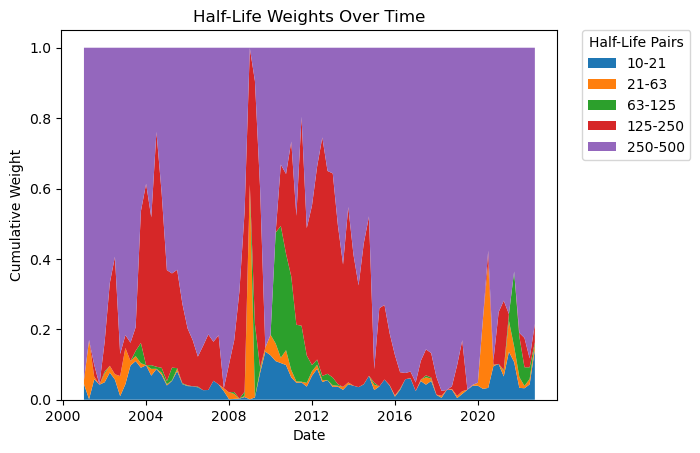

In [28]:
# Look at half-life weights over the full period
start_date = pd.to_datetime("2000-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

quarterly_weights  = pd.DataFrame(weights).T.resample("QE").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Half-Life Pairs')
plt.title('Half-Life Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Weight')


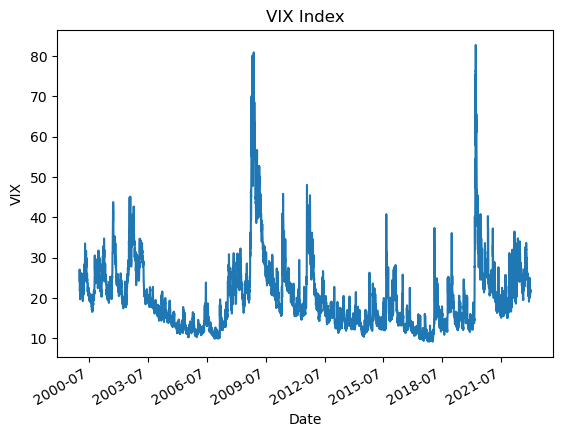

In [29]:
# Plot VIX
plt.plot(vix.index, vix.vix)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=36))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.title('VIX Index')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.show()

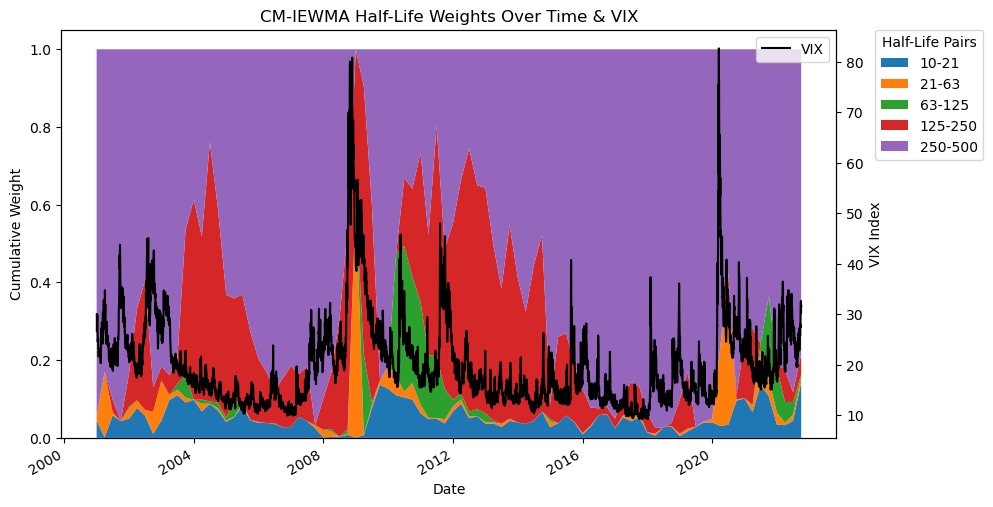

In [30]:
start_date = pd.to_datetime("2000-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

# Resample and select the data range for weights
quarterly_weights = pd.DataFrame(weights).T.resample("QE").mean().loc[start_date:end_date]

# Filter the VIX data to match the date range of the stack plot
vix_filtered = vix.loc[(vix.index >= quarterly_weights.index.min()) & (vix.index <= quarterly_weights.index.max())]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stack plot on the first y-axis
ax1.stackplot(
    quarterly_weights.index, 
    quarterly_weights.values.T, 
    labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs]
)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Weight')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Half-Life Pairs')
ax1.set_title('CM-IEWMA Half-Life Weights Over Time & VIX')

# Create the second y-axis for the VIX plot
ax2 = ax1.twinx()

# Plot the filtered VIX on the second y-axis
vix_line, = ax2.plot(vix_filtered.index, vix_filtered.vix, color='black', label='VIX')

# Set the label for the secondary y-axis
ax2.set_ylabel('VIX Index')

# Add grid lines and formatting
ax1.grid(False)
ax2.grid(False)

# Rotate the x-axis labels for better readability
fig.autofmt_xdate()

# Add legend for VIX on ax2
ax2.legend([vix_line], ['VIX'], loc='upper right')

# Show the plot
plt.show()


Text(0, 0.5, 'Half-life (Days)')

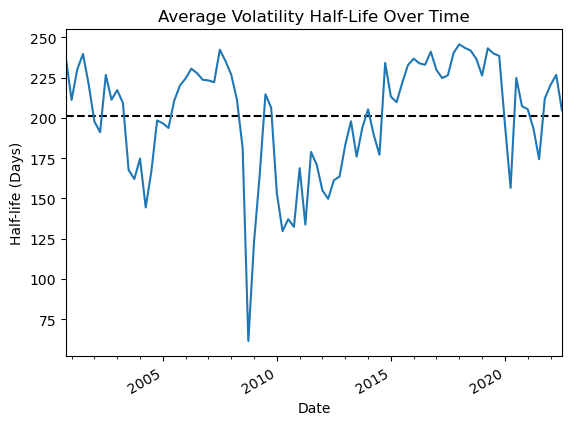

In [31]:
# Look at average volatility half-life over the full sample period

halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1)
plt.gcf().autofmt_xdate()
plt.title('Average Volatility Half-Life Over Time')
plt.xlabel('Date')
plt.ylabel('Half-life (Days)')

# Crisis Case Study

In [10]:
dot_com_crash = returns.loc['2000-03-01': '2002-03-01']
vix_dot_com = vix.loc['2000-03-01': '2002-03-01']
gfc = returns.loc['2007-02-01': '2009-04-01']
vix_gfc = vix.loc['2007-02-01': '2009-04-01']
covid = returns.loc['2020-02-20': '2020-04-20']
vix_covid = vix.loc['2020-02-20': '2020-04-20']

gfc_events = [
    ('2007-09-14', 'Run on Northern Rock begins'),
    ('2008-03-16', 'Bear Stearns rescued by JP Morgan'),
    ('2008-09-15', 'Lehman Brothers bankruptcy'),
    ('2008-10-03', 'TARP bailout approved'),
    ('2008-12-16', 'Fed cuts interest rates to near zero'),
    ('2009-03-05', 'Dow Jones hits bottom')
]

dot_com_events = [
    ('2001-03-01', 'U.S. enters recession'),
    ('2001-09-11', 'September 11th Attacks'),
    ('2001-10-01', 'Enron scandal'),

]

covid_events = [
    ('2020-03-11', 'WHO declares COVID pandemic'),
    ('2020-03-13', 'COVID declared national emergency'),
    ('2020-04-02', 'Global cases surpassed 1M')

]

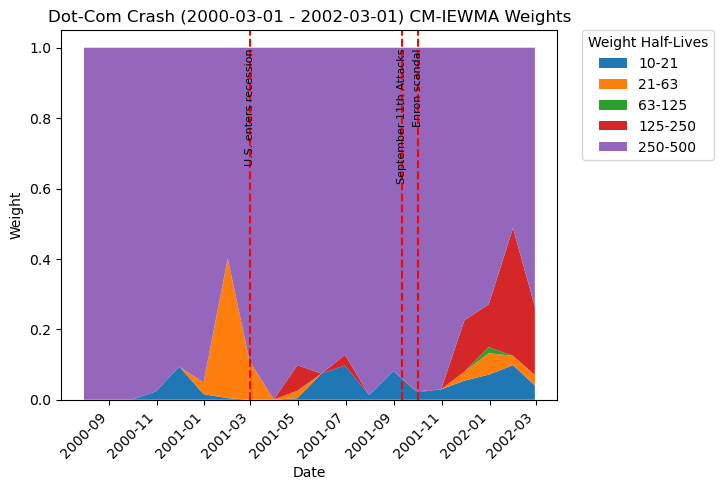

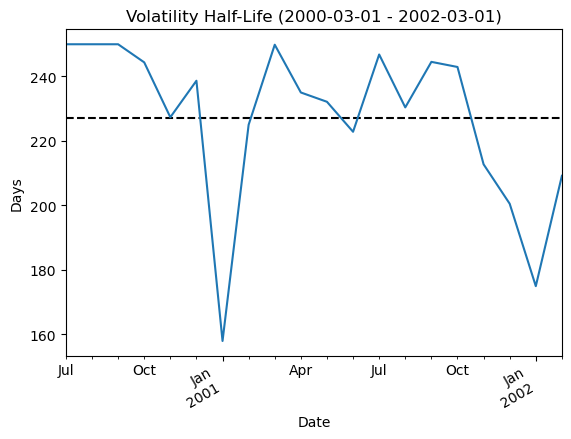

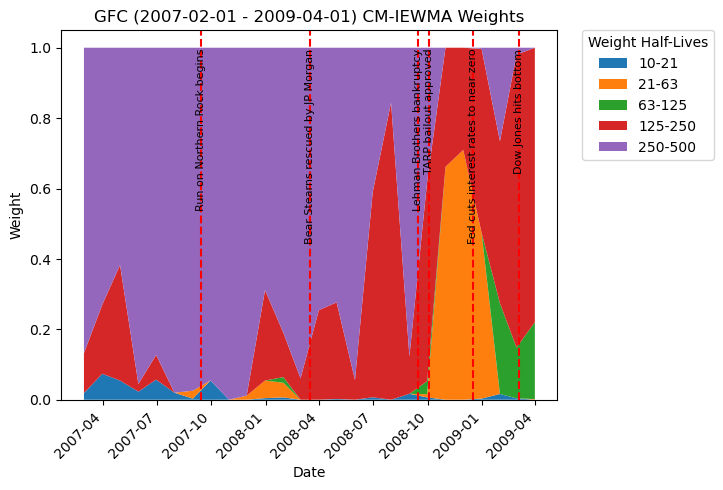

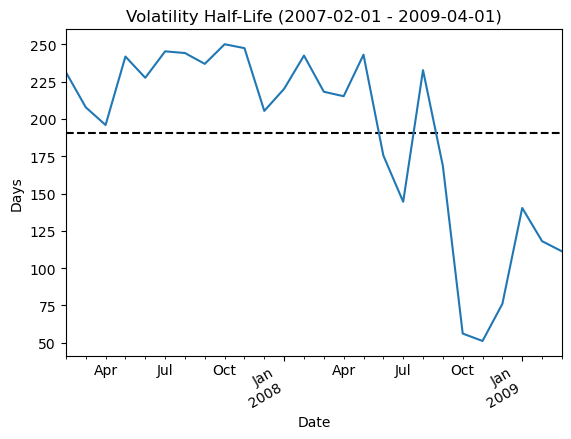

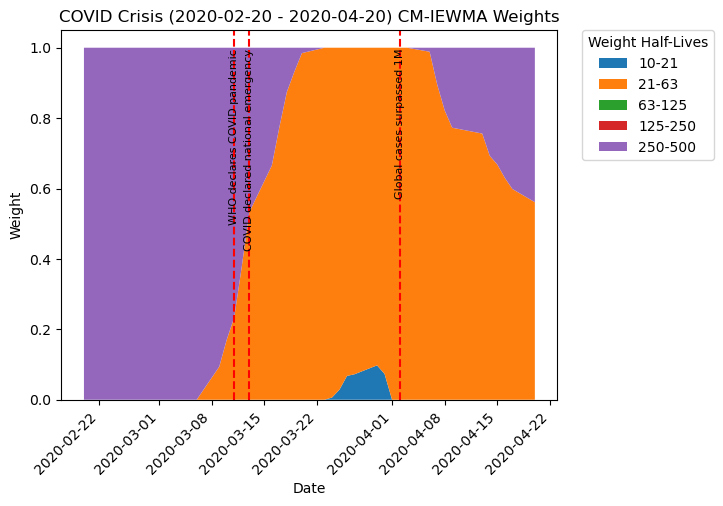

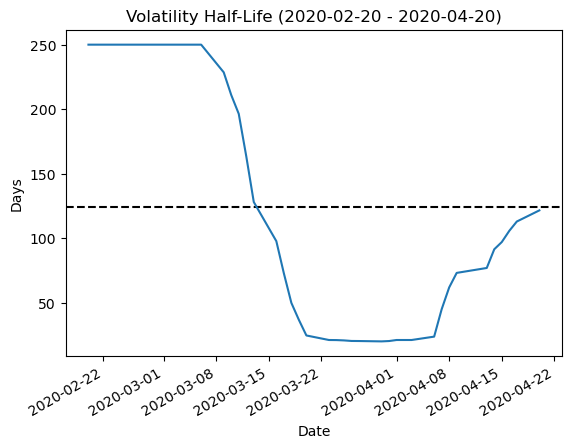

In [34]:
periods = [('2000-03-01', '2002-03-01', 'Dot-Com Crash'), ('2007-02-01', '2009-04-01', 'GFC'), ('2020-02-20', '2020-04-20', 'COVID Crisis')]

for i, per in enumerate(periods):
    start_date = pd.to_datetime(per[0], format="%Y-%m-%d")
    end_date = pd.to_datetime(per[1], format="%Y-%m-%d")

    if i < 2:
        re_weights = pd.DataFrame(weights).T.resample("ME").mean().loc[start_date:end_date]
    else:
        re_weights = pd.DataFrame(weights).T.loc[start_date:end_date]
    
    plt.figure()
    plt.stackplot(re_weights.index, re_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{per[2]} ({per[0]} - {per[1]}) CM-IEWMA Weights')

    if per[2] == 'GFC':
        for event_date, event_label in gfc_events:
            event_date = pd.to_datetime(event_date, format="%Y-%m-%d")
            plt.axvline(event_date, color='red', linestyle='--', linewidth=1.5)
            plt.text(event_date, plt.ylim()[1] * 0.95, event_label, rotation=90, color='black', fontsize=8, ha='center', va='top')

    elif per[2] == 'Dot-Com Crash':
        for event_date, event_label in dot_com_events:
            event_date = pd.to_datetime(event_date, format="%Y-%m-%d")
            plt.axvline(event_date, color='red', linestyle='--', linewidth=1.5)
            plt.text(event_date, plt.ylim()[1] * 0.95, event_label, rotation=90, color='black', fontsize=8, ha='center', va='top')

    elif per[2] == 'COVID Crisis':
        for event_date, event_label in covid_events:
            event_date = pd.to_datetime(event_date, format="%Y-%m-%d")
            plt.axvline(event_date, color='red', linestyle='--', linewidth=1.5)
            plt.text(event_date, plt.ylim()[1] * 0.95, event_label, rotation=90, color='black', fontsize=8, ha='center', va='top')

    plt.legend(title='Weight Half-Lives', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    plt.figure()
    halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
    (re_weights * halflifes_vola).sum(axis=1).plot()
    plt.axhline((re_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1)
    plt.gcf().autofmt_xdate()
    plt.title(f'Volatility Half-Life ({per[0]} - {per[1]})')
    plt.ylabel('Days')
    plt.xlabel('Date')
    plt.show()

## Compare Half-Life Weights with VIX

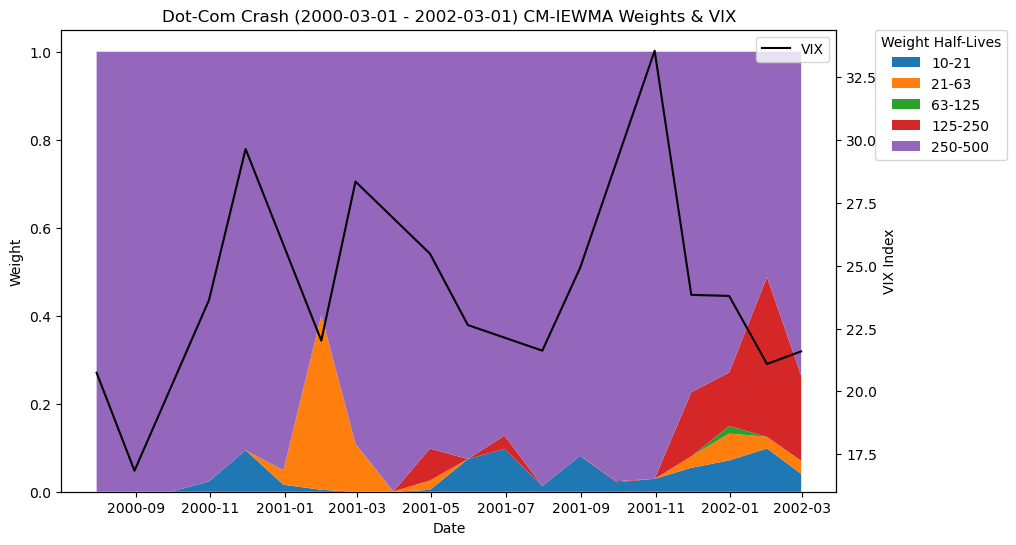

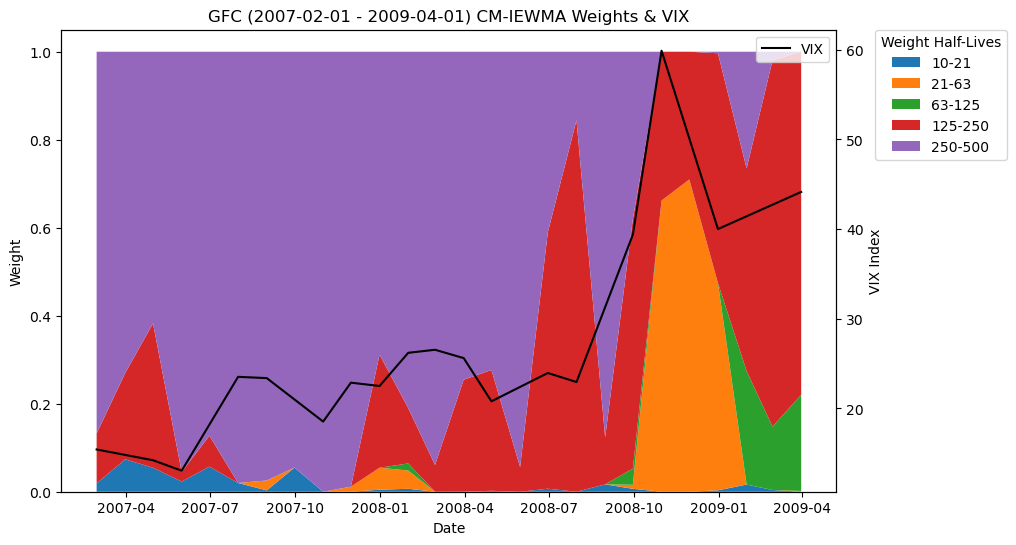

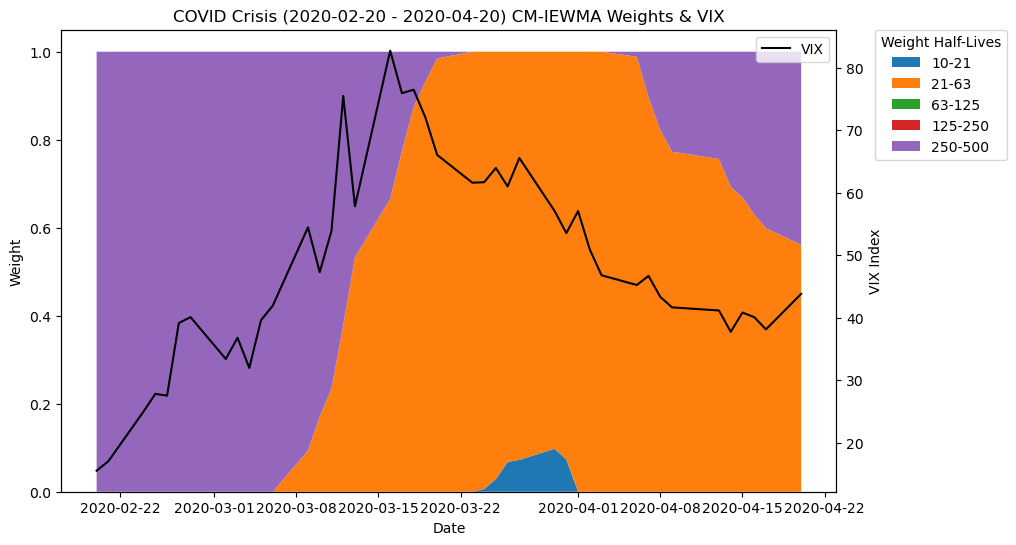

In [22]:
for i, per in enumerate(periods):
    start_date = pd.to_datetime(per[0], format="%Y-%m-%d")
    end_date = pd.to_datetime(per[1], format="%Y-%m-%d")
    
    # Resample or filter weights for the period
    if i < 2:
        re_weights = pd.DataFrame(weights).T.resample("ME").mean().loc[start_date:end_date]
    else:
        re_weights = pd.DataFrame(weights).T.loc[start_date:end_date]

    # Filter VIX data to match the index range of re_weights
    vix_filtered = vix.loc[vix.index.isin(re_weights.index)]

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the stackplot on the first y-axis
    ax1.stackplot(
        re_weights.index, 
        re_weights.values.T, 
        labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs]
    )
    
    # Set labels and titles
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weight')
    ax1.legend(title='Weight Half-Lives', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax1.set_title(f"{per[2]} ({per[0]} - {per[1]}) CM-IEWMA Weights & VIX")
    
    # Create a second y-axis for the VIX plot
    ax2 = ax1.twinx()
    
    # Plot VIX on the second y-axis
    ax2.plot(vix_filtered.index, vix_filtered.vix, color='black', label='VIX')
    ax2.set_ylabel('VIX Index')

    # Add the VIX legend
    ax2.legend(loc='upper right')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Show the plot
    plt.show()


Compute correlations of shortest two half-life weights with VIX during crisis periods

In [19]:
gfc_weights = pd.DataFrame()
gfc_dates = []
date_range = pd.date_range(start='2007-02-01', end='2009-04-01')

for date in date_range:
    if date in weights.keys():
        gfc_dates.append(date)
        x = pd.DataFrame(weights[pd.to_datetime(date)]).T
        gfc_weights = pd.concat([gfc_weights, x])

gfc_weights.index = gfc_dates
gfc_weights['short_hl_weight'] = gfc_weights['10-21'] + gfc_weights['21-63']

vix_gfc = vix_gfc.loc[gfc_weights.index]
vix_gfc = vix_gfc.groupby(vix_gfc.index).apply(lambda x: x.sample(n=1))
vix_gfc.index = vix_gfc.index.droplevel(0)

np.corrcoef(gfc_weights['short_hl_weight'], vix_gfc['vix'])


array([[1.        , 0.71844908],
       [0.71844908, 1.        ]])

In [20]:
dot_com_weights = pd.DataFrame()
dot_com_dates = []
date_range = pd.date_range(start='2000-03-01', end='2002-03-01')

for date in date_range:
    if date in weights.keys():
        dot_com_dates.append(date)
        x = pd.DataFrame(weights[pd.to_datetime(date)]).T
        dot_com_weights = pd.concat([dot_com_weights, x])

dot_com_weights.index = dot_com_dates
dot_com_weights['short_hl_weight'] = dot_com_weights['10-21'] + dot_com_weights['21-63']

vix_dot_com = vix_dot_com.loc[dot_com_weights.index]
vix_dot_com = vix_dot_com.groupby(vix_dot_com.index).apply(lambda x: x.sample(n=1))
vix_dot_com.index = vix_dot_com.index.droplevel(0)

np.corrcoef(dot_com_weights['short_hl_weight'], vix_dot_com['vix'])

array([[ 1.        , -0.07402814],
       [-0.07402814,  1.        ]])

In [23]:
covid_weights = pd.DataFrame()
covid_dates = []
date_range = pd.date_range(start='2020-02-20', end='2020-04-20')

for date in date_range:
    if date in weights.keys():
        covid_dates.append(date)
        x = pd.DataFrame(weights[pd.to_datetime(date)]).T
        covid_weights = pd.concat([covid_weights, x])

covid_weights.index = covid_dates
covid_weights['short_hl_weight'] = covid_weights['10-21'] + covid_weights['21-63']

vix_covid = vix_covid.loc[covid_weights.index]
vix_covid = vix_covid.groupby(vix_covid.index).apply(lambda x: x.sample(n=1))
vix_covid.index = vix_covid.index.droplevel(0)

np.corrcoef(covid_weights['short_hl_weight'], vix_covid['vix'])

array([[1.       , 0.6265657],
       [0.6265657, 1.       ]])

In [63]:
# Compare CM-IEWMA to other estimators

# rolling_window
rw = rolling_window(returns, rw_memory)

# ewma
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))

# iterated_ewma  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0], cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    # quarter = (t.month-1)//3 + 1
    month = t.month
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.month == month)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.month == month)].values, axis=0)
    prescient[t] = pd.DataFrame(cov + np.outer(mean, mean), index=returns.columns, columns=returns.columns)


Running iterated_ewma


## Performance Statistics

In [64]:
# Calculate mean, max, and std dev of monthly MSE for each crisis period
for i, per in enumerate(periods):
    start_date = pd.to_datetime(per[0], format="%Y-%m-%d")
    end_date = pd.to_datetime(per[1], format="%Y-%m-%d")
    print(f'{start_date} to {end_date} \n')

    names = ["RW", "EWMA", "IEWMA", "CM-IEWMA", "Prescient"]

    predictors_temp = [rw, ewma, iewma, cm_iewma, prescient]
    predictors = []

    for predictor in predictors_temp:
        predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

    for i, predictior in enumerate(predictors):
        MSE_temp = MSE(returns, predictior).resample("ME").mean()


        print("\n" + names[i])
        print(f"mean: {MSE_temp.mean():.6f}")
        print(f"std: {MSE_temp.std():.6f}")
        print(f"max: {MSE_temp.max():.6f}")

2000-03-01 00:00:00 to 2002-03-01 00:00:00 


RW
mean: 0.140844
std: 0.126276
max: 0.396135

EWMA
mean: 0.140715
std: 0.126555
max: 0.395516

IEWMA
mean: 0.140899
std: 0.127167
max: 0.395212

CM-IEWMA
mean: 0.120161
std: 0.121881
max: 0.395701

Prescient
mean: 0.131272
std: 0.119542
max: 0.380386
2007-02-01 00:00:00 to 2009-04-01 00:00:00 


RW
mean: 0.323053
std: 0.623072
max: 2.508646

EWMA
mean: 0.322723
std: 0.620699
max: 2.502501

IEWMA
mean: 0.316085
std: 0.605742
max: 2.466524

CM-IEWMA
mean: 0.317818
std: 0.600467
max: 2.443050

Prescient
mean: 0.280275
std: 0.520870
max: 2.139800
2020-02-20 00:00:00 to 2020-04-20 00:00:00 


RW
mean: 1.411146
std: 2.031201
max: 3.750894

EWMA
mean: 1.398594
std: 2.017348
max: 3.722650

IEWMA
mean: 1.376257
std: 1.992215
max: 3.671835

CM-IEWMA
mean: 1.351485
std: 1.960526
max: 3.610913

Prescient
mean: 1.048941
std: 1.463100
max: 2.732263
